![QuantConnect Logo](https://cdn.quantconnect.com/web/i/icon.png)
<hr>

# Research to Production
## Long Short Term Memory
---------
### Introduction
This notebook explains how to you can use the Research Environment to develop and test a Long Short Term Memory hypothesis, then put the hypothesis in production.

<a href="https://www.quantconnect.com/docs/v2/research-environment/tutorials/research-to-production/long-short-term-memory">Documentation</a>

Recurrent neural networks (RNN) are a powerful tool in deep learning. These models quite accurately mimic how humans process sequencial information and learn. Unlike traditional feedforward neural networks, RNNs have memory. That is, information fed into them persists and the network is able to draw on this to make inferences.

Long Short-term Memory (LSTM) is a type of RNN. Instead of one layer, LSTM cells generally have four, three of which are part of "gates" -- ways to optionally let information through. The three gates are commonly referred to as the forget, input, and output gates. The forget gate layer is where the model decides what information to keep from prior states. At the input gate layer, the model decides which values to update. Finally, the output gate layer is where the final output of the cell state is decided. Essentially, LSTM separately decides what to remember and the rate at which it should update.

<img src="https://cdn.quantconnect.com/i/tu/lstm-cell-2.png">
<b>An exmaple of a LSTM cell: x is the input data, c is the long-term memory, h is the current state and serve as short-term memory, $\sigma$ and $tanh$ is the non-linear activation function of the gates.</b><br/>
<i><font font-size="2px">Image source: https://en.wikipedia.org/wiki/Long_short-term_memory#/media/File:LSTM_Cell.svg</font></i>

### Create Hypothesis
LSTM models have produced some great results when applied to time-series prediction. One of the central challenges with conventional time-series models is that, despite trying to account for trends or other non-stationary elements, it is almost impossible to truly predict an outlier like a recession, flash crash, liquidity crisis, etc. By having a long memory, LSTM models are better able to capture these difficult trends in the data without suffering from the level of overfitting a conventional model would need in order to capture the same data.

For a very basic application, we're hypothesizing LSTM can offer an accurate prediction in future price.

### Prerequisites
If you use Python, you must understand how to work with pandas DataFrames and Series. If you are not familiar with pandas, refer to the <a href="https://pandas.pydata.org/docs/">pandas documentation</a>.

### Import Libraries
We'll need to import libraries to help with data processing, visualisation and deep learning. Import keras, sklearn, numpy and matplotlib libraries by the following:

In [1]:
from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

import numpy as np
from matplotlib import pyplot as plt

Using TensorFlow backend.


### Get Historical Data
To begin, we retrieve historical data for research.

In [2]:
# Instantiate a QuantBook.
qb = QuantBook()

# Select the desired tickers for research.
assets = "SPY"

# Call the AddEquity method with the tickers, and its corresponding resolution. Then store their Symbols. Resolution.Minute is used by default. 
qb.AddEquity(assets, Resolution.Minute)

# Call the History method with qb.Securities.Keys for all tickers, time argument(s), and resolution to request historical data for the symbol.
history = qb.History(qb.Securities.Keys, datetime(2019, 1, 1), datetime(2021, 12, 31), Resolution.Daily)
history

close        high         low        open  \
symbol           time                                                         
SPY R735QTJ8XC9X 2019-01-03  237.859386  238.838661  233.847208  233.942283   
                 2019-01-04  232.183390  236.328673  231.669984  236.071970   
                 2019-01-05  239.960550  240.645092  234.997619  235.396935   
                 2019-01-08  241.852548  243.326215  239.304530  240.312328   
                 2019-01-09  244.124848  244.638254  241.500770  244.210416   
...                                 ...         ...         ...         ...   
                 2021-12-24  470.600000  472.190000  468.640000  468.770000   
                 2021-12-28  477.260000  477.310000  472.010000  472.090000   
                 2021-12-29  476.870000  478.810000  476.065000  477.800000   
                 2021-12-30  477.480000  478.540000  475.950000  477.040000   
                 2021-12-31  476.160000  479.000000  475.680000  477.980000   

                                  volume  
symbol           time                     
SPY R735QTJ8XC9X 2019-01-03  118905707.0  
                 2019-01-04  126457562.0  
                 2019-01-05  134243794.0  
                 2019-01-08   97588325.0  
                 2019-01-09   96136795.0  
...                                  ...  
                 2021-12-24   48545204.0  
                 2021-12-28   47739260.0  
                 2021-12-29   38617395.0  
                 2021-12-30   48659382.0  
                 2021-12-31   45696339.0  

[756 rows x 5 columns]

### Preparing Data
We'll have to process our data as well as build the LSTM model before testing the hypothesis. We would scale our data to for better covergence.

In [3]:
# Select the close column and then call the unstack method.
close = history['close'].unstack(level=0)

# Initialize MinMaxScaler to scale the data onto [0,1].
scaler = MinMaxScaler(feature_range = (0, 1))

# Transform our data.
df = pd.DataFrame(scaler.fit_transform(close), index=close.index)

# Select input data
input_ = df.iloc[1:]

# Shift the data for 1-step backward as training output result.
output = df.shift(-1).iloc[:-1]

# Split the data into training and testing sets. In this example, we use the first 80% data for trianing, and the last 20% for testing.
splitter = int(input_.shape[0] * 0.8)
X_train = input_.iloc[:splitter]
X_test = input_.iloc[splitter:]
y_train = output.iloc[:splitter]
y_test = output.iloc[splitter:]

# Build feauture and label sets (using number of steps 60, and feature rank 1).
features_set = []
labels = []
for i in range(60, X_train.shape[0]):
    features_set.append(X_train.iloc[i-60:i].values.reshape(-1, 1))
    labels.append(y_train.iloc[i])
features_set, labels = np.array(features_set), np.array(labels)
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))

### Build Model
We construct the LSTM model.

In [4]:
# Build a Sequential keras model.
model = Sequential()

# Create the model infrastructure.
# Add our first LSTM layer - 50 nodes
model.add(LSTM(units = 50, return_sequences=True, input_shape=(features_set.shape[1], 1)))
# Add Dropout layer to avoid overfitting
model.add(Dropout(0.2))
# Add additional layers
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units = 5))
model.add(Dense(units = 1))

# Compile the model. We use Adam as optimizer for adpative step size and MSE as loss function since it is continuous data.
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mae', 'acc'])

# Set early stopping callback method.
callback = EarlyStopping(monitor='loss', patience=3, verbose=1, restore_best_weights=True)

# Display the model structure.
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_______________________________________

In [5]:
# Fit the model to our data, running 20 training epochs.
model.fit(features_set, labels, epochs = 20, callbacks=[callback])


Epoch 1/20
544/544 [==============================] - 59s 109ms/step - loss: 0.0434 - mae: 0.1503 - acc: 0.0018
Epoch 2/20
544/544 [==============================] - 57s 105ms/step - loss: 0.0085 - mae: 0.0701 - acc: 0.0018
Epoch 3/20
544/544 [==============================] - 43s 79ms/step - loss: 0.0053 - mae: 0.0524 - acc: 0.0018
Epoch 4/20
544/544 [==============================] - 40s 73ms/step - loss: 0.0040 - mae: 0.0448 - acc: 0.0018
Epoch 5/20
544/544 [==============================] - 43s 78ms/step - loss: 0.0037 - mae: 0.0442 - acc: 0.0018
Epoch 6/20
544/544 [==============================] - 38s 71ms/step - loss: 0.0036 - mae: 0.0443 - acc: 0.0018
Epoch 7/20
544/544 [==============================] - 31s 58ms/step - loss: 0.0035 - mae: 0.0439 - acc: 0.0018
Epoch 8/20
544/544 [==============================] - 42s 76ms/step - loss: 0.0037 - mae: 0.0438 - acc: 0.0018
Epoch 9/20
544/544 [==============================] - 35s 64ms/step - loss: 0.0040 - mae: 0.0464 - acc: 0.001

Note that different training session's results will not be the same since the batch is randomly selected.

### Test the Hypothesis
We would test the performance of this ML model to see if it could predict 1-step forward price precisely. To do so, we would compare the predicted and actual prices.

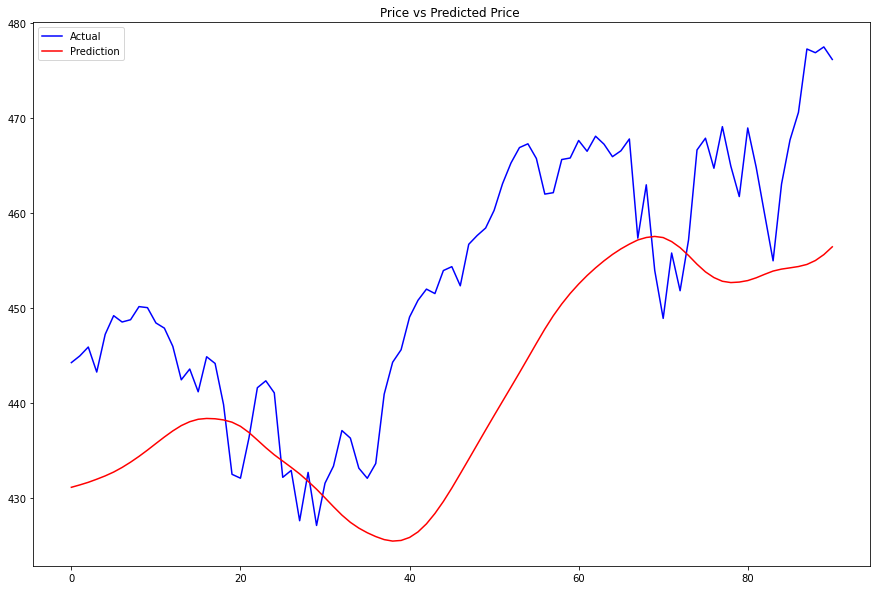

In [6]:
# Get testing set features for input.
test_features = []
for i in range(60, X_test.shape[0]):
    test_features.append(X_test.iloc[i-60:i].values.reshape(-1, 1))
test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))

# Make predictions.
predictions = model.predict(test_features)

# Transform predictions back to original data-scale.
predictions = scaler.inverse_transform(predictions)
actual = scaler.inverse_transform(y_test.values)

# Plot the results
plt.figure(figsize=(15, 10))
plt.plot(actual[60:], color='blue', label='Actual')
plt.plot(predictions , color='red', label='Prediction')
plt.title('Price vs Predicted Price ')
plt.legend()
plt.show()